https://github.com/ovh/ai-training-examples/blob/main/notebooks/computer-vision/image-segmentation/tensorflow/brain-tumor-segmentation-unet/notebook_image_segmentation_unet.ipynb

https://keras.io/examples/vision/deeplabv3_plus/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# downloading libraries
!pip install --upgrade nibabel==3.2
!pip install pyradiomics
!pip install nilearn --upgrade
!pip install SimpleITK
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
from glob import glob
import nibabel as nib
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
from sklearn.model_selection import train_test_split
import cv2
import random
import torch
import torch.nn as nn
import skimage.color 
from skimage.color import rgb2gray
from torch.utils.data import Dataset

In [ ]:
mal_dir = '/content/drive/MyDrive/Master degree AI/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS1_MALIGNANT'
ben_dir = '/content/drive/MyDrive/Master degree AI/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS2_BENIGN'
#ben_dir = '/content/drive/MyDrive/Master degree AI/Healthcare/CLASS2_BENIGN'
#mal_dir = '/content/drive/MyDrive/Master degree AI/Healthcare/CLASS1_MALIGNANT'
malignant = [f.path for f in os.scandir(mal_dir) if f.is_dir()]# list of paths to malignant CT scans
benign = [f.path for f in os.scandir(ben_dir) if f.is_dir()]# list of paths to benign CT scans
malignant = sorted(malignant) # sort malignant
benign = sorted(benign) # sort benign
num_patients = 30 
patient_count = 0 

**segmentation**

In [ ]:
data_dir = malignant + benign

In [ ]:
from torchvision.transforms import functional as TF
# dataset
class NiftiDataset(Dataset):

    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir # list of paths to CT scans
        self.transform = transform

    def __len__(self):
        return len(self.data_dir) # number of CT scans

    def __getitem__(self, index):
      for index in self.data_dir: # for each CT scan
        patient_id = os.path.basename(index)[:7] # get the patient id
        ct_path = os.path.join(index, f'{patient_id}_PT_partition.nii') # get the CT scan
        ct_mask_path = os.path.join(index, f'{patient_id}_PT_mask.nii') # get the CT mask
        ct_scan = nib.load(ct_path).get_fdata() #load CT scan
        ct_mask = nib.load(ct_mask_path).get_fdata() #load CT mask
        
        non_zero_counts = np.sum(ct_mask != 0, axis=(0, 1)) # count non-zero voxels
        mask_slice_idx = np.argmax(non_zero_counts) # get the index of the largest non-zero voxel
        ct_mask = ct_mask[:, :, mask_slice_idx] # mask out the largest non-zero voxel
        ct_scan = ct_scan[:, :, mask_slice_idx] # mask out the largest non-zero voxel
        
        # Find non-zero region of the mask
        non_zero_indices = np.nonzero(ct_mask)
        min_x, max_x = np.min(non_zero_indices[0]), np.max(non_zero_indices[0])
        min_y, max_y = np.min(non_zero_indices[1]), np.max(non_zero_indices[1])
        ct_scan = ct_scan[min_x:max_x + 30, min_y:max_y + 30] # scan crop 
        ct_mask = ct_mask[min_x:max_x + 30, min_y:max_y + 30] # mask crop

        # Normalize the CT scan
        ct_scan = (ct_scan - np.min(ct_scan)) / (np.max(ct_scan) - np.min(ct_scan))
                
        ct_scan = TF.resize(TF.to_tensor(ct_scan).float(), (64, 64)) # resize to 64x64 because otherwise it will not finish
        ct_mask = TF.resize(TF.to_tensor(ct_mask).float(), (64, 64)) # resize to 64x64
        
        if self.transform:
            ct_scan = self.transform(ct_scan)
            ct_mask = self.transform(ct_mask)
        return ct_scan, ct_mask # return CT scan and mask

In [ ]:
dataset = NiftiDataset(data_dir) # create a dataset

In [ ]:
# data augmentation from torchvision
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),  # 50% probability to flip horizontally
    transforms.RandomVerticalFlip(p=0.5),    # 50% probability to flip vertically
    transforms.RandomRotation(20),           # Random rotation of the image
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation (10% of image size in both x and y directions)
    #transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),      # Random zoom (scale image between 80% to 120% of its original size)
    transforms.ToTensor()
])

In [ ]:
from sklearn.model_selection import train_test_split
train_ds, val_ds = train_test_split(dataset, test_size=0.3, shuffle=True, random_state=42) # split dataset into 60%train and 40%validation
#train_ds, test_ds = train_test_split(dataset, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
# Create the augmented dataset by applying transformations
augmented_dataset = NiftiDataset(data_dir, transform=transform)
# Concatenate the original dataset and augmented dataset
train_ds = torch.utils.data.ConcatDataset([train_ds, augmented_dataset])

In [ ]:
# get an item from the dataset
dataset[58]

(tensor([[[0.8131, 0.8320, 0.8484,  ..., 0.0825, 0.0993, 0.1148],
          [0.8554, 0.8344, 0.8563,  ..., 0.0995, 0.1199, 0.1122],
          [0.8838, 0.8400, 0.8694,  ..., 0.1542, 0.1301, 0.0910],
          ...,
          [0.2129, 0.1352, 0.0946,  ..., 0.5930, 0.5749, 0.5705],
          [0.1924, 0.1442, 0.1025,  ..., 0.5536, 0.5509, 0.5746],
          [0.1641, 0.1151, 0.0652,  ..., 0.5256, 0.5416, 0.5949]]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]))

In [ ]:
len(dataset) # number of CT scans

60

In [ ]:
patient_id = 16 # patient id
ct_image, ct_mask = dataset[patient_id - 1] # get CT scan

In [ ]:
print(ct_image.shape) # check the shape of CT scan
print(ct_mask.shape) # check the shape of CT mask
# print(pet_image.shape)
# print(pet_mask.shape)

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])


In [ ]:
dataset.__getitem__(58) # get an item from the dataset

(tensor([[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          ...,
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
batch_size = 2 # number of images in each batch
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, # number of images in each batch
                        shuffle=True, num_workers=2)

val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, # number of images in each batch
                        shuffle=False, num_workers=2)

#test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
#                        shuffle=False, num_workers=0)

In [ ]:
dataiter = iter(train_dl) # iterator
ct, msk =next(dataiter) # get an item from the iterator
print(type(ct)) #<class 'torch.Tensor'>
print(ct.shape) 
print(msk.shape) 

<class 'torch.Tensor'>
torch.Size([2, 1, 64, 64])
torch.Size([2, 1, 64, 64])


In [ ]:
len(train_dl) # number of batches in training

51

In [ ]:
len(val_dl) # number of batches in validation

9

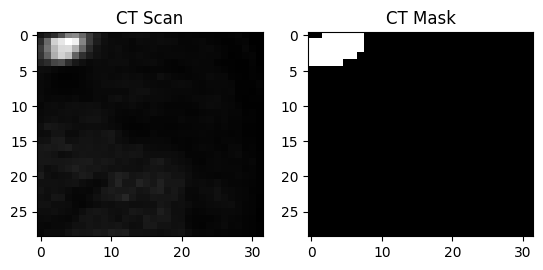

In [ ]:
#visualize a crop
ct_scan = nib.load('/content/drive/MyDrive/Master degree AI/Healthcare/CLASS1_MALIGNANT/LCp0020_biobank/LCp0020_PT_partition.nii').get_fdata()
ct_mask = nib.load('/content/drive/MyDrive/Master degree AI/Healthcare/CLASS1_MALIGNANT/LCp0020_biobank/LCp0020_PT_mask.nii').get_fdata()
non_zero_counts = np.sum(ct_mask != 0, axis=(0, 1))
mask_slice_idx = np.argmax(non_zero_counts)
ct_mask = ct_mask[:, :, mask_slice_idx]
ct_scan = ct_scan[:, :, mask_slice_idx]
non_zero_indices = np.nonzero(ct_mask)
min_x, max_x = np.min(non_zero_indices[0]), np.max(non_zero_indices[0])
min_y, max_y = np.min(non_zero_indices[1]), np.max(non_zero_indices[1])

ct_scan_cropped = ct_scan[min_x:max_x + 25, min_y:max_y + 25]
ct_mask_cropped = ct_mask[min_x:max_x + 25, min_y:max_y + 25]

plt.subplot(1, 2, 1)
plt.imshow(ct_scan_cropped, cmap='gray')
plt.title('CT Scan')

plt.subplot(1, 2, 2)
plt.imshow(ct_mask_cropped, cmap='gray')
plt.title('CT Mask')

plt.show()

In [ ]:
from torchsummary import summary
#net = UNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#net.to(device)

In [ ]:
input_shape = (1, 64, 64)
# Create a random input tensor
#input_tensor = torch.randn(2, *input_shape).to(device)
input_tensor = torch.randn(2, *input_shape)
input_tensor.shape

torch.Size([2, 1, 64, 64])

In [ ]:
# defining the model
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.encoder1 = DoubleConv(in_channels, 64)
        self.encoder2 = DoubleConv(64, 128)
        self.encoder3 = DoubleConv(128, 256)
        self.encoder4 = DoubleConv(256, 512)
        self.bottleneck = DoubleConv(512, 1024)
        self.decoder1 = UpConv(1024 + 512, 512)
        self.decoder2 = UpConv(512 + 256, 256)
        self.decoder3 = UpConv(256 + 128, 128)
        self.decoder4 = UpConv(128 + 64, 64)  # Update the number of input channels here
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Contracting Path
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)

        # Bottleneck
        x5 = self.bottleneck(x4)

        # Expanding Path
        x = self.decoder1(x5, x4)
        x = self.decoder2(x, x3)
        x = self.decoder3(x, x2)
        x = self.decoder4(x, x1)

        # Output Convolution
        x = self.out_conv(x)
        x = self.sigmoid(x)

        # Bilinear interpolation for upsampling
        x = nn.functional.interpolate(x, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)

        return x

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diff_h = x2.size()[2] - x1.size()[2]
        diff_w = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, (diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [ ]:
model = UNet()  
model.to(device)
# summary(model, input_tensor.shape[1:]) 

UNet(
  (encoder1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (encoder2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (encoder3): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(128, 256, 

In [ ]:
def dice_coefficient(pred, target):
    smooth = 1e-5  # Smoothing term to avoid division by zero
    intersection = (pred * target).sum() # Numerator
    union = pred.sum() + target.sum() # Denominator
    dice = (2.0 * intersection + smooth) / (union + smooth) 
    return dice 

# pixel accuracy
def accuracy(preds, targets):
    preds = preds > 0.5  # Apply threshold to convert to binary mask
    targets = targets > 0.5 # Apply threshold to convert to binary mask
    correct_pixels = (preds == targets).sum().item() # Number of correct pixels
    total_pixels = preds.numel()# Total number of pixels
    accuracy = correct_pixels / total_pixels # Calculate accuracy
    return accuracy

# function to compute the focal loss
def focal_loss(inputs, targets, alpha=0.25, gamma=2):
    inputs = inputs.sigmoid() # Apply sigmoid to convert to binary mask
    pt = torch.where(targets == 1, inputs, 1 - inputs) # Apply threshold
    return -alpha * (1 - pt) ** gamma * torch.log(pt) # Compute focal loss

# function to compute the F1 score
def calculate_f1_score(predictions, targets):
    # Calculate true positives, false positives, and false negatives
    true_positives = torch.sum(predictions * targets)
    false_positives = torch.sum(predictions * (1 - targets))
    false_negatives = torch.sum((1 - predictions) * targets)

    # Calculate precision, recall, and F1 score
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)  # Add epsilon to avoid division by zero

    return f1_score

# function to compute the IoU
def calculate_iou(predictions, targets):
    intersection = torch.sum(predictions * targets)
    union = torch.sum(predictions) + torch.sum(targets) - intersection
    iou = intersection / (union + 1e-7)  # Add epsilon to avoid division by zero

    return iou

# Nuova sezione

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # Define adam optimizer
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
def plot_masks(image, predicted_mask, mask):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze().cpu(), cmap='gray')
    plt.title('Crop from PET Slice')

    plt.subplot(1, 3, 2)
    predicted_mask = predicted_mask.squeeze().cpu().numpy()  # Convert predicted_mask to a NumPy array
    predicted_mask = np.where(predicted_mask >= 0.87, 1, 0)  # Apply threshold of 0.5
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(mask.squeeze().cpu(), cmap='gray')
    plt.title('Ground Truth Mask')

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
def train(model, optimizer, criterion, train_dl, val_dl, num_epochs):

    #device = torch.device("cuda")
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    val_ious = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_accuracy=0.0
        num_train_samples = 0

        for images, masks in train_dl: # Iterate over batches
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad() # Clear gradients
            masks = masks.float()  # Convert masks to float type
            masks = masks / 255.0 # Normalize masks
            # Forward pass
            outputs = model(images) 
            loss = criterion(outputs, masks) # Compute loss
            
            # Backward pass and optimization
            loss.backward() # Compute gradients
            optimizer.step() # Update weights

            # Compute accuracy
            train_loss += loss.item()* images.size(0)
            train_accuracy += accuracy(outputs, masks) * images.size(0)
            num_train_samples += images.size(0)
            train_loss /= len(train_dl.dataset)
            train_accuracy /= len(train_dl.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Compute validation metrics
        model.eval() # Set model to evaluation mode 
        val_loss = 0.0
        val_accuracy = 0.0
        dice_score = 0.0
        val_f1 = 0.0
        val_iou = 0.0
        num_val_samples = 0
        
        with torch.no_grad(): # Disable gradient calculation
            #val_loss = 0.0
            #val_accuracy = 0.0
            #val_f1 = 0.0
            #val_iou = 0.0
            for images, masks in val_dl:# Iterate over batches
                images = images.to(device)
                masks = masks.to(device)
                masks = masks.float()  # Convert masks to float type
                masks = masks / 255.0 # Normalize masks
                
                with torch.no_grad():# Disable gradient calculation
                  outputs = model(images)# Forward pass
                  loss = criterion(outputs, masks)# Compute loss
                val_loss += loss.item()# Update running loss
                val_loss += loss.item()* images.size(0)
                val_accuracy += accuracy(outputs, masks) * images.size(0)
                val_f1 += calculate_f1_score(outputs, masks) * images.size(0)
                val_iou += calculate_iou(outputs, masks) * images.size(0)
                
                # Compute Dice coefficient
                preds = (outputs > 0.5).float()# Apply threshold
                dice_score += dice_coefficient(preds, masks)# Update running dice
                num_val_samples += images.size(0) # Update number of samples 
                

        
            val_loss /= len(val_dl)# Update running average loss
            dice_score /= len(val_dl)# Update running average dice
            val_accuracy /= len(val_dl.dataset)# Update running average accuracy            
            val_f1 /= num_val_samples
            val_iou /= num_val_samples
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)
        val_ious.append(val_iou)

        # Print metrics
        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Dice Score: {dice_score:.4f}, Val F1: {val_f1:.4f}, Val IoU Score: {val_iou:.4f}')

        
    
    # Plotting predicted mask for a random CT slice
    model.eval()
    with torch.no_grad():
        random_index = random.randint(0, len(val_dl.dataset) - 1)
        image, mask = val_dl.dataset[random_index]
        image = image.unsqueeze(0)
        image = image.to(device)  # Move image tensor to the same device as the model
        mask = mask.to(device)  # Move mask tensor to the same device as the model
        predicted_mask = model(image).squeeze()

    plot_masks(image, predicted_mask,mask)

Epoch 1/1: Train Loss: 0.0165, Train Acc: 0.0193, Val Loss: 2.5324, Val Acc: 0.9551, Dice Score: 0.0074, Val F1: 0.0012, Val IoU Score: 0.0006


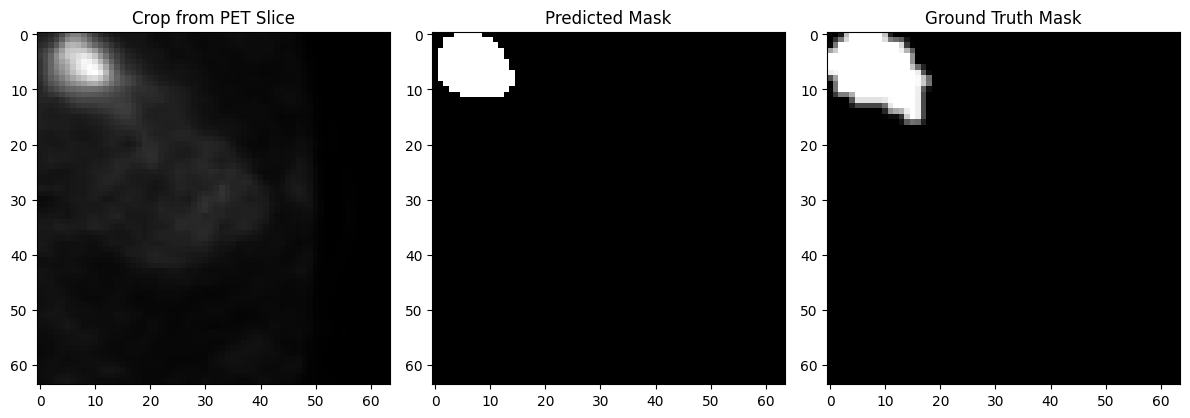

In [ ]:
# train the unet model
# should increase the number of epochs when gpu is available
train(model, optimizer, criterion, train_dl, val_dl, num_epochs=1) 

## finetuning

In [ ]:
!pip install segmentation-models-pytorch
import torch
import segmentation_models_pytorch as smp
from PIL import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torchvision.models.segmentation as models

res = models.deeplabv3_resnet101(weight='IMAGENET1K_2').to(device)

# Modify the number of input and output channels
res.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=3, bias=False) # Change the number of input and output channels in the backbone

res.classifier[4] = nn.Conv2d(256, 1, kernel_size=1) # Change the number of input and output channels in the classifier

# Print the modified model
print(res)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
!pip install torch --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os

os.environ['TORCH_USE_CUDA_DSA'] = '1'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(res.parameters(), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

def train_tuned(model, optimizer, criterion, train_dl, val_dl, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    val_ious = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_accuracy = 0.0
        num_train_samples = 0

        for images, masks in train_dl:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            masks = masks.float()
            masks = masks / 255.0
            
            outputs = model(images)
            outputs = outputs['out']
            outputs = torch.sigmoid(outputs)  # Apply sigmoid activation
            loss = criterion(outputs, masks)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            train_accuracy += accuracy(outputs, masks) * images.size(0)
            num_train_samples += images.size(0)
        
        train_loss /= len(train_dl.dataset)
        train_accuracy /= len(train_dl.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        dice_score = 0.0
        val_f1 = 0.0
        val_iou = 0.0
        num_val_samples = 0
        
        with torch.no_grad():
            for images, masks in val_dl:
                images = images.to(device)
                masks = masks.to(device)
                
                masks = masks.float()
                masks = masks / 255.0
                
                outputs = model(images)
                outputs = outputs['out']
                outputs = torch.sigmoid(outputs)  # Apply sigmoid activation
                loss = criterion(outputs, masks)
                
                val_loss += loss.item() * images.size(0)
                val_accuracy += accuracy(outputs, masks) * images.size(0)
                val_f1 += calculate_f1_score(outputs, masks) * images.size(0)
                val_iou += calculate_iou(outputs, masks) * images.size(0)
                
                preds = (outputs > 0.5).float()
                dice_score += dice_coefficient(preds, masks)
                num_val_samples += images.size(0)
            
            val_loss /= len(val_dl)
            dice_score /= len(val_dl)
            val_accuracy /= len(val_dl.dataset)
            val_f1 /= num_val_samples
            val_iou /= num_val_samples
            
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            val_f1_scores.append(val_f1)
            val_ious.append(val_iou)
            
            print(f'Epoch {epoch+1}/{num_epochs}: 'f'Train Loss: {train_loss:.4f}, 'f'Train Acc: {train_accuracy:.4f}, 'f'Val Loss: {val_loss:.4f}, 'f'Val Acc: {val_accuracy:.4f}, 'f'Dice Score: {dice_score:.4f},'f'Val F1: {val_f1:.4f}, 'f'Val IoU Score: {val_iou:.4f}')
    
    # Save the trained model
    torch.save(model.state_dict(), 'trained_model.pth')

    # Plotting predicted and real mask for a random CT slice
    model.eval()
    with torch.no_grad():
        random_index = random.randint(0, len(val_dl.dataset) - 1)
        image, mask = val_dl.dataset[random_index]
        image = image.unsqueeze(0).to(device)
        predicted_mask = model(image)
        predicted_mask = predicted_mask['out'].squeeze().cpu().numpy()
  # Convert predicted_mask to a NumPy array
        predicted_mask = np.where(predicted_mask >= 0.74, 1, 0)# Apply sigmoid activation

        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(image.squeeze().cpu(), cmap='hot')
        plt.title('Cropped PET Slice')
        plt.subplot(1, 3, 2)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.subplot(1, 3, 3)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title('GT Mask')
        plt.show()

In [ ]:

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available


In [ ]:
res = res.to(device)
optimizer = torch.optim.Adam(res.parameters(), lr=1e-4)
#criterion = torch.nn.BCELoss()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 1/15: Train Loss: 0.9250, Train Acc: 0.8840, Val Loss: 1.8401, Val Acc: 1.0000, Dice Score: 0.0000,Val F1: 0.0004, Val IoU Score: 0.0002


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 2/15: Train Loss: 0.8428, Train Acc: 0.9995, Val Loss: 1.4866, Val Acc: 1.0000, Dice Score: 0.0000,Val F1: 0.0005, Val IoU Score: 0.0002


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 3/15: Train Loss: 0.7765, Train Acc: 1.0000, Val Loss: 1.4070, Val Acc: 1.0000, Dice Score: 0.0000,Val F1: 0.0003, Val IoU Score: 0.0002


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 4/15: Train Loss: 0.7448, Train Acc: 1.0000, Val Loss: 1.4164, Val Acc: 1.0000, Dice Score: 0.0000,Val F1: 0.0003, Val IoU Score: 0.0002


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 5/15: Train Loss: 0.7296, Train Acc: 1.0000, Val Loss: 1.3913, Val Acc: 1.0000, Dice Score: 0.0000,Val F1: 0.0003, Val IoU Score: 0.0001


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 6/15: Train Loss: 0.7219, Train Acc: 1.0000, Val Loss: 1.3942, Val Acc: 1.0000, Dice Score: 0.0000,Val F1: 0.0003, Val IoU Score: 0.0002


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 7/15: Train Loss: 0.7147, Train Acc: 1.0000, Val Loss: 1.3925, Val Acc: 1.0000, Dice Score: 0.0000,Val F1: 0.0004, Val IoU Score: 0.0002


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 8/15: Train Loss: 0.7109, Train Acc: 1.0000, Val Loss: 1.3871, Val Acc: 1.0000, Dice Score: 0.0000,Val F1: 0.0003, Val IoU Score: 0.0002


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 9/15: Train Loss: 0.7074, Train Acc: 1.0000, Val Loss: 1.3963, Val Acc: 1.0000, Dice Score: 0.0000,Val F1: 0.0004, Val IoU Score: 0.0002


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 10/15: Train Loss: 0.7057, Train Acc: 1.0000, Val Loss: 1.4060, Val Acc: 1.0000, Dice Score: 0.0000,Val F1: 0.0004, Val IoU Score: 0.0002


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 11/15: Train Loss: 0.7047, Train Acc: 1.0000, Val Loss: 1.3952, Val Acc: 1.0000, Dice Score: 0.0000,Val F1: 0.0007, Val IoU Score: 0.0003


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 12/15: Train Loss: 0.7031, Train Acc: 1.0000, Val Loss: 1.3872, Val Acc: 1.0000, Dice Score: 0.0000,Val F1: 0.0006, Val IoU Score: 0.0003


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 13/15: Train Loss: 0.7021, Train Acc: 1.0000, Val Loss: 1.3926, Val Acc: 1.0000, Dice Score: 0.0000,Val F1: 0.0003, Val IoU Score: 0.0002


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 14/15: Train Loss: 0.7005, Train Acc: 1.0000, Val Loss: 1.3922, Val Acc: 1.0000, Dice Score: 0.0000,Val F1: 0.0004, Val IoU Score: 0.0002


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 15/15: Train Loss: 0.7000, Train Acc: 1.0000, Val Loss: 1.3978, Val Acc: 1.0000, Dice Score: 0.0000,Val F1: 0.0004, Val IoU Score: 0.0002


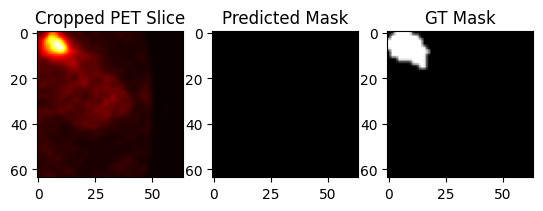

In [ ]:
# Usage:
train_tuned(res, optimizer, criterion, train_dl, val_dl, num_epochs=15)

# FINE (ignora queste celle)

RuntimeError: ignored

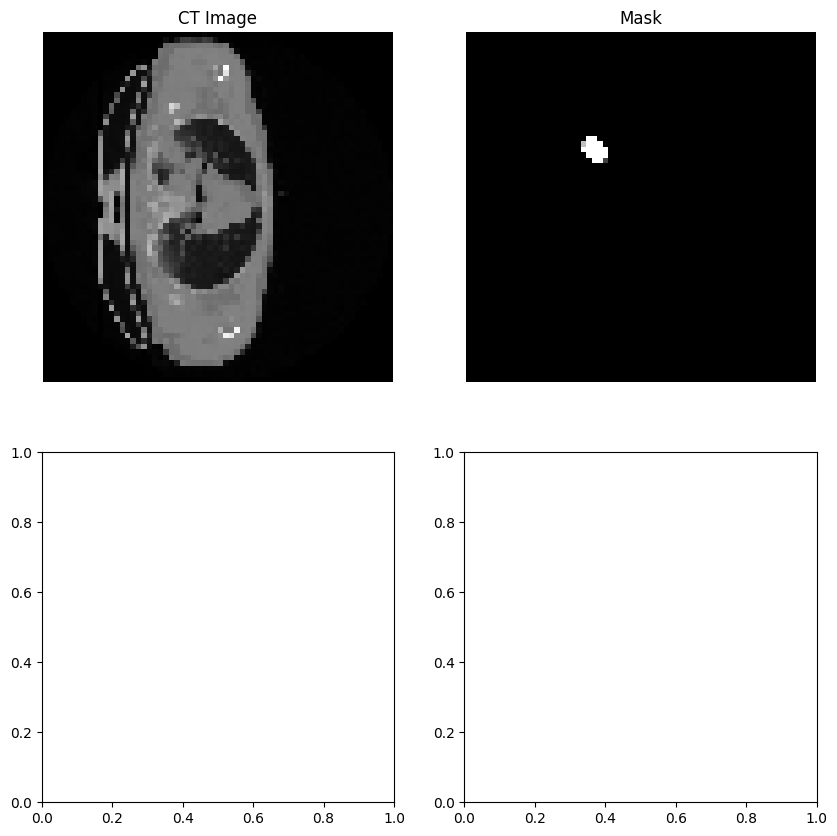

In [ ]:
import matplotlib.pyplot as plt

def plot_images(images, masks, num_images=2):
    # Seleziona un sottoinsieme di immagini e maschere da visualizzare
    images = images[:num_images]
    masks = masks[:num_images]
    
    # Configura la griglia per visualizzare le immagini
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 10))
    
    for i, (image, mask) in enumerate(zip(images, masks)):
        # Plot dell'immagine CT
        axes[i, 0].imshow(image.squeeze(), cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title('CT Image')
        
        # Plot della maschera
        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Mask')
        # Plot the CT scan, ground truth mask, and the predicted mask side by side






        ct_scan_slice_pil = transforms.ToPILImage()(image)
        # Apply the transform to the CT scan slice
        ct_scan_slice_normalized = transform(ct_scan_slice_pil)

        # Repeat the single channel to create 3 channels
        ct_scan_slice_normalized = torch.cat([ct_scan_slice_normalized] * 3)

        # Expand dimensions to match the model input
        ct_scan_slice_normalized = ct_scan_slice_normalized.unsqueeze(0)

        # Generate the predicted mask
        model.eval()
        with torch.no_grad():
            output = model(ct_scan_slice_normalized)
            predicted_mask = torch.sigmoid(output).squeeze().numpy()
            
            plt.tight_layout()
            plt.show()

        axes[i, 2].imshow(predicted_mask, cmap='gray')
        axes[i, 2].set_title('Predicted Mask')

# Chiamata alla funzione per visualizzare i plot delle immagini e delle maschere
plot_images(dataset.__getitem__(0)[0], dataset.__getitem__(0)[1], num_images=2)

In [ ]:
# Preprocess the CT scan data
def preprocess_ct_scannn(ct_scan_path):
    ct_scan = nib.load(ct_scan_path)
    ct_scan_data = ct_scan.get_fdata()
    ct_scan_data = (ct_scan_data - np.min(ct_scan_data)) / (np.max(ct_scan_data) - np.min(ct_scan_data))
    ct_scan_data = np.expand_dims(ct_scan_data, axis=0)
    return torch.tensor(ct_scan_data, dtype=torch.float32)

In [ ]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=6042e603688db0944ea9271a015d9f6644025b292e996b3f4454012117c24280
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=6f979b9dc95186f207d2ba301cb107bd8ef6bf10de52c6acc17ea5aeef7f1c1c
  Stored in directory: /root/.cache/pip/w

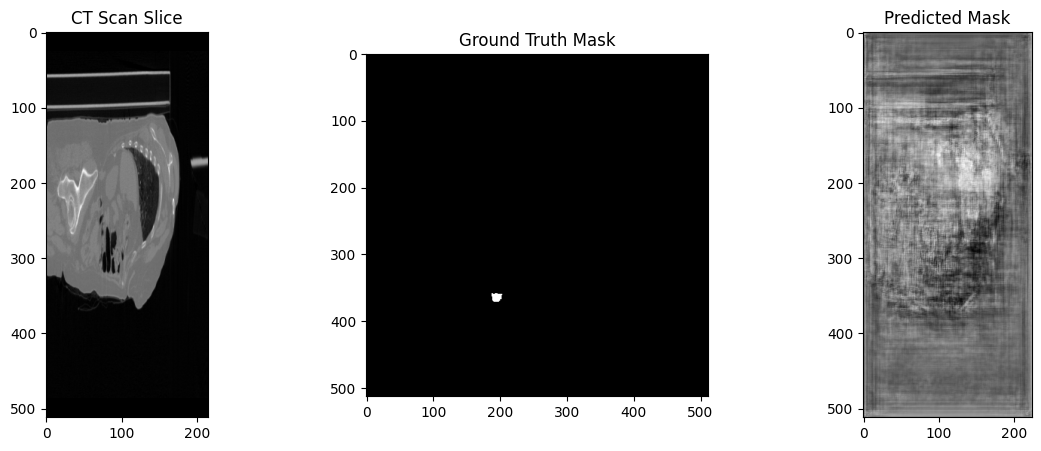

In [ ]:
import torch
import segmentation_models_pytorch as smp
import torchvision.transforms as transforms
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Preprocess the CT scan data
def preprocess_ct_scan(ct_scan_path):
    ct_scan = nib.load(ct_scan_path)
    ct_scan_data = ct_scan.get_fdata()
    ct_scan_data = (ct_scan_data - np.min(ct_scan_data)) / (np.max(ct_scan_data) - np.min(ct_scan_data))
    ct_scan_data = np.expand_dims(ct_scan_data, axis=0)
    return torch.tensor(ct_scan_data, dtype=torch.float32)

# Load the pretrained U-Net model
model = smp.Unet('resnet34', encoder_weights='imagenet')

# Load the CT scan
ct_scan_path = '/content/drive/MyDrive/Master degree AI/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS2_BENIGN/LCp0001_biobank/LCp0001_CT_partition.nii'
#ct_scan_path='/content/drive/MyDrive/Master degree AI/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS1_MALIGNANT/LCp0016_biobank/LCp0016_PT_partition.nii'
ct_scan_data = preprocess_ct_scan(ct_scan_path)

# Load the ground truth mask
gt_mask_path = '/content/drive/MyDrive/Master degree AI/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS2_BENIGN/LCp0001_biobank/LCp0001_CT_mask.nii'
#gt_mask_path='/content/drive/MyDrive/Master degree AI/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS1_MALIGNANT/LCp0016_biobank/LCp0016_PT_mask.nii'
gt_mask_data = nib.load(gt_mask_path).get_fdata()

# Find the slice indices with a mass in the ground truth mask
mass_slice_indices = np.where(np.sum(gt_mask_data, axis=(0, 1)) > 0)[0]

# Randomly select one slice with a mass
selected_index = np.random.choice(mass_slice_indices)
ct_scan_slice = ct_scan_data[:, selected_index, :, :]

# Convert CT scan slice tensor to PIL Image
ct_scan_slice_pil = transforms.ToPILImage()(ct_scan_slice)

# Define the transform to resize and normalize the input image
transform = transforms.Compose([
    transforms.Resize((512, 224)),  # Resize to smaller dimensions
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Apply the transform to the CT scan slice
ct_scan_slice_normalized = transform(ct_scan_slice_pil)

# Repeat the single channel to create 3 channels
ct_scan_slice_normalized = torch.cat([ct_scan_slice_normalized] * 3)

# Expand dimensions to match the model input
ct_scan_slice_normalized = ct_scan_slice_normalized.unsqueeze(0)

# Generate the predicted mask
model.eval()
with torch.no_grad():
    output = model(ct_scan_slice_normalized)
    predicted_mask = torch.sigmoid(output).squeeze().numpy()

# Plot the CT scan, ground truth mask, and the predicted mask side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(ct_scan_slice.squeeze(), cmap='gray')
axes[0].set_title('CT Scan Slice')

axes[1].imshow(gt_mask_data[..., selected_index], cmap='gray')
axes[1].set_title('Ground Truth Mask')

axes[2].imshow(predicted_mask, cmap='gray')
axes[2].set_title('Predicted Mask')

plt.show()